In [1]:
import re
import pandas as pd
import json

# Load the full log content
log_path = "/Users/cgopal/Downloads/browser_ml_semantic__history_search_threshold_test.log"
with open(log_path, "r") as f:
    log_text = f.read()



# Block-level pattern to extract each test (query type + doc type + threshold)
test_block_pattern = re.compile(
    r"Running (?P<queryType>\w+) → (?P<docType>\w+) test at threshold (?P<threshold>[\d.]+).*?"
    r"(Matched|No match).*?"
    r"Threshold [\d.]+ \| (?P<profile>profile_.*?\.json) \| Recall@1: (?P<correct>\d+)/(?P<total>\d+) \((?P<accuracy>[\d.]+)%",
    re.DOTALL,
)

test_blocks = list(test_block_pattern.finditer(log_text))
print(f"Matched {len(test_blocks)} test blocks")

query_pattern = re.compile(
    r"(Matched|No match) query: (.*?)\n(?:INFO results: (.*?)(?=\n(?:Matched|No match) query:|\nINFO Threshold|$))?",
    re.DOTALL,
)


results = []

# Iterate through blocks
for block in test_block_pattern.finditer(log_text):
    queryType = block.group("queryType").strip()
    docType = block.group("docType").strip()
    threshold = float(block.group("threshold"))
    profile = block.group("profile").strip()
    correct = int(block.group("correct"))
    total = int(block.group("total"))
    accuracy = float(block.group("accuracy"))

    block_text = block.group(0)
    matches = list(query_pattern.finditer(block_text))
    print(f"  {len(matches)} queries matched in block {queryType} → {docType} @ {threshold}")


    for qmatch in query_pattern.finditer(block_text):
        status, query, result_json = qmatch.groups()
        matched = status == "Matched"
        query = query.strip()
        top_titles = []

        if result_json:
            try:
                clean_json = result_json.strip().replace("\n", "").replace("\r", "")
                parsed = json.loads(clean_json)
                top_titles = [r.get("title", "") for r in parsed if isinstance(r, dict)]
            except Exception as e:
                top_titles = [f"[parse error] {e}"]

        results.append({
            "query_type": queryType,
            "doc_type": docType,
            "threshold": threshold,
            "profile": profile,
            "query": query,
            "matched": matched,
            "top_titles": top_titles,
            "accuracy": accuracy,
            "recall": float(correct)/float(total),
        })

# Convert to DataFrame
df = pd.DataFrame(results)

# Filter only valid query/doc types
valid_query_types = ["shortQ", "longQ"]
valid_doc_types = ["shortD", "longD"]

df["query_type"] = df["query_type"].str.strip()
df["doc_type"] = df["doc_type"].str.strip()

filtered_df = df[
    df["query_type"].isin(valid_query_types) &
    df["doc_type"].isin(valid_doc_types)
].copy()


Matched 20 test blocks
  15 queries matched in block longQ → longD @ 0.25
  15 queries matched in block longQ → longD @ 0.4
  15 queries matched in block longQ → longD @ 0.5
  15 queries matched in block longQ → longD @ 0.6
  15 queries matched in block longQ → longD @ 0.75
  15 queries matched in block shortQ → longD @ 0.25
  15 queries matched in block shortQ → longD @ 0.4
  15 queries matched in block shortQ → longD @ 0.5
  15 queries matched in block shortQ → longD @ 0.6
  15 queries matched in block shortQ → longD @ 0.75
  15 queries matched in block longQ → shortD @ 0.25
  15 queries matched in block longQ → shortD @ 0.4
  15 queries matched in block longQ → shortD @ 0.5
  15 queries matched in block longQ → shortD @ 0.6
  15 queries matched in block longQ → shortD @ 0.75
  15 queries matched in block shortQ → shortD @ 0.25
  15 queries matched in block shortQ → shortD @ 0.4
  15 queries matched in block shortQ → shortD @ 0.5
  15 queries matched in block shortQ → shortD @ 0.6
  

In [2]:
filtered_df.drop(['accuracy', 'top_titles'], axis=1)

,query_type,doc_type,threshold,profile,query,matched,recall
0,longQ,longD,0.25,profile_longQ_longD_df.json,alternative medicine to manage ringing in my ear,False,0.000000
1,longQ,longD,0.25,profile_longQ_longD_df.json,solutions for noisy neighbors,False,0.000000
2,longQ,longD,0.25,profile_longQ_longD_df.json,how to train a cat to use the litter box,False,0.000000
3,longQ,longD,0.25,profile_longQ_longD_df.json,how to make your dog loss weight,False,0.000000
4,longQ,longD,0.25,profile_longQ_longD_df.json,what are the best foods for dogs,False,0.000000
...,...,...,...,...,...,...,...
295,shortQ,shortD,0.75,profile_shortQ_shortD_df.json,amyloidosis,True,0.933333
296,shortQ,shortD,0.75,profile_shortQ_shortD_df.json,alopecia,True,0.933333
297,shortQ,shortD,0.75,profile_shortQ_shortD_df.json,dermatitis,True,0.933333
298,shortQ,shortD,0.75,profile_shortQ_shortD_df.json,coffee shop,True,0.933333


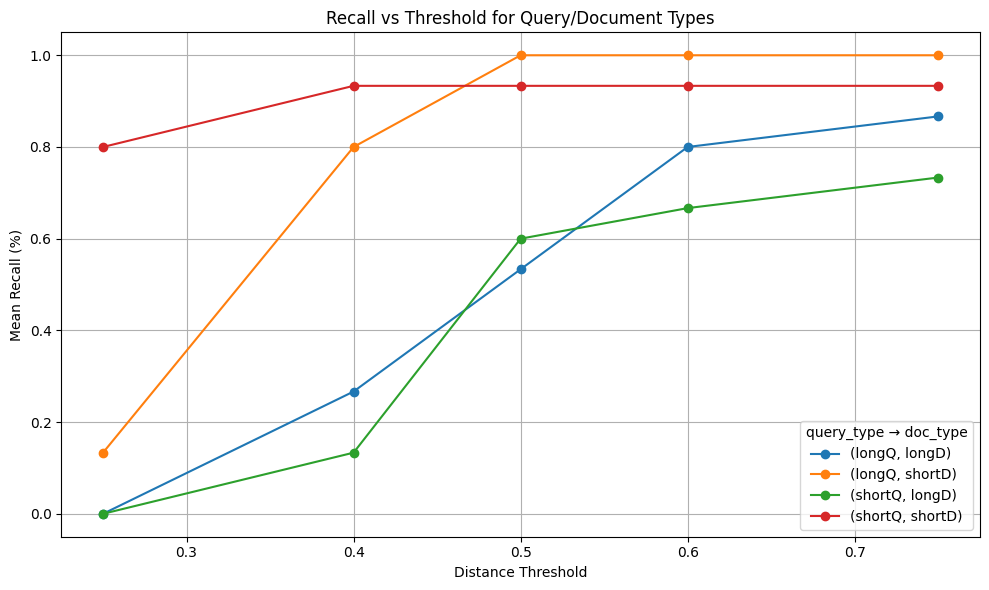

In [3]:
import matplotlib.pyplot as plt

# Assume the dataframe is already loaded as `df`

# Group by query/doc type and threshold, then compute mean accuracy
grouped = filtered_df.groupby(["query_type", "doc_type", "threshold"]).agg(
    mean_accuracy=("recall", "mean")
).reset_index()

# Pivot table for plotting
pivot = grouped.pivot_table(
    index="threshold",
    columns=["query_type", "doc_type"],
    values="mean_accuracy"
)

# Plotting
pivot.plot(marker='o', figsize=(10, 6))
plt.title("Recall vs Threshold for Query/Document Types")
plt.ylabel("Mean Recall (%)")
plt.xlabel("Distance Threshold")
plt.grid(True)
plt.legend(title="query_type → doc_type")
plt.tight_layout()
plt.show()

In [4]:
pivot

query_type     longQ              shortQ          
doc_type       longD    shortD     longD    shortD
threshold                                         
0.25        0.000000  0.133333  0.000000  0.800000
0.40        0.266667  0.800000  0.133333  0.933333
0.50        0.533333  1.000000  0.600000  0.933333
0.60        0.800000  1.000000  0.666667  0.933333
0.75        0.866667  1.000000  0.733333  0.933333